In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from nltk.tokenize.casual import casual_tokenize 

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.naive_bayes import GaussianNB

import warnings
warnings.filterwarnings("ignore")

# Step 1: Get Data

I found a way to very easily make NLP topics much more interpretable and allow for topic analysis. Topics created by TruncatedSVD can be used to create classifiers with very high accuracy, but there is not good visibility into the topic components. But running the tf-idf vocabulary against the fit TruncatedSVD model, we can get good interpretability of what the topics are comprised of, and very quickly and easily. 

First things first, let's get the data.

In [2]:
src_dir = r'C:\Users\groov\PythonCode\output\trump_tweets\\'
hostile_file = src_dir + 'trump_tweets_hostile_clf.csv'

clf_df = pd.read_csv(hostile_file, header=None)
clf_df.columns = ['ts', 'tweet', 'label']
clf_df.drop('ts', axis=1, inplace=True)
clf_df.reset_index(drop=True, inplace=True)

clf_df.head()

,tweet,label
0,no matter what you do for the do nothing democ...,1
1,"them happy, or even a little bit satisfied. th...",1
2,the most often used phrase in the lamestream m...,1
3,just like i was right on ventilators (our coun...,0
4,.@foxnews “dems say president trump is trying ...,0


To maximize accuracy, we are not going to remove stopwords. Let's also set aside the data for tf-idf.

In [3]:
tweets = clf_df['tweet']
labels = clf_df['label']

del(clf_df)

# Step 2: TF-IDF Vectorize

Next, we need tf-idf vectors. We could have used count vectors instead, but classifier accuracy would likely suffer. I prefer tf-idf. 

In [4]:
tfidf = TfidfVectorizer(tokenizer=casual_tokenize, ngram_range=(1,3), lowercase=True, sublinear_tf=True)
tfidf_docs = tfidf.fit_transform(raw_documents=tweets)
tfidf_docs

<1432x76541 sparse matrix of type '<class 'numpy.float64'>'
	with 162868 stored elements in Compressed Sparse Row format>

# Step 3: Topic Modeling with TruncatedSVD

In [5]:
svd = TruncatedSVD(n_components=100, n_iter=100, random_state=1337)
svd_topic_vectors = svd.fit_transform(tfidf_docs)

Now, we can throw the tf-idf vocabulary at svd to get topics for each word, and this is very similar to the components we can pull from LDiA. 

# Step 4: Interrogate Topics
First things first, let's build the vocabulary and then use it to create topics for each vocabulary entry.

In [6]:
vocab = tfidf.vocabulary_
vocab = list(vocab.keys())
len(vocab)

76541

One way you can inspect topic components is by doing the following:

In [7]:
components = pd.DataFrame(svd.components_).T
components.index = vocab
components.columns = ['topic_' + str(c) for c in components.columns]
components.head(5)

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,...,topic_90,topic_91,topic_92,topic_93,topic_94,topic_95,topic_96,topic_97,topic_98,topic_99
no,0.146201,-0.072476,0.007980,0.093029,0.033812,0.014741,-0.043927,0.018565,0.034399,-0.014867,...,-0.003505,-0.021327,-0.023053,-0.011646,0.011227,0.044047,-0.015445,0.033471,-0.005507,-0.027067
matter,0.010567,-0.012430,-0.001637,-0.002576,-0.000891,0.001275,-0.025100,0.003758,0.001245,0.005733,...,-0.017527,-0.007355,0.006762,-0.030077,0.007113,-0.009242,0.005274,0.008296,-0.036450,-0.007891
what,0.005955,-0.006949,-0.000908,-0.001522,-0.000186,0.000868,-0.014822,0.002446,0.000567,0.003918,...,-0.012538,-0.006324,0.003883,-0.014158,0.000246,-0.006439,0.003078,0.003353,-0.021413,-0.006383
you,0.000256,-0.000359,-0.000067,-0.000070,-0.000025,0.000021,-0.000661,0.000014,0.000148,-0.000260,...,-0.001508,-0.000282,-0.000226,-0.001451,-0.000573,-0.000347,0.001899,-0.001052,-0.002159,-0.001059
do,0.000631,-0.000109,-0.000477,-0.000086,-0.000231,0.000716,-0.000510,0.002994,-0.000461,0.000479,...,-0.002255,-0.000271,0.000742,0.001055,0.001251,0.001515,-0.000982,-0.000598,0.000806,0.000496


In [8]:
components.loc['do nothing democrats'].sort_values(ascending=False).head(10)

topic_92    0.003090
topic_83    0.002262
topic_87    0.002153
topic_59    0.001811
topic_86    0.001704
topic_96    0.001616
topic_80    0.001492
topic_62    0.001490
topic_63    0.001459
topic_88    0.001363
Name: do nothing democrats, dtype: float64

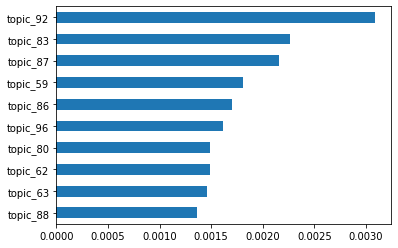

In [9]:
components.loc['do nothing democrats'].sort_values(ascending=False).head(10).plot.barh()
plt.gca().invert_yaxis()

In [10]:
def show_topic_values(topic, count=100):
    return components[topic].sort_values(ascending=False)[0:count].index.values

In [11]:
show_topic_values('topic_83', 50)

array(['again , far', 'two years ago', 'iraq was going', 'when iraq was',
       '. president xi', 'decision to open', 'sullivan is',
       'to let florida', 'went on before', 'only to the', 'is an',
       'soon be putting', 'everyday to', 'be putting more', '. china is',
       'he fights', 'your reputation will', '“ let the', 'other central',
       ', they led', 'and even', 'sections of the',
       'numbers are horrendous', 'c . that', '. that you',
       'their poll numbers', ', ideally', 'dead , their', 'peter ’',
       'the ( phony', 'matter what .', '185', 'have ,', 'control , the',
       'easily', 'average', 'releasing', 'such talk', 'i ask',
       'a fantastic football', 'democrats at', 'approve more money',
       'battle with', 'i didn ’', 'alaska while', 'an incredible',
       'their leader ,', 'incredible fighter', 'comey still runs',
       'offered isis'], dtype=object)

But I am finding that this is not so clear. A better way seems to be to run the vocabulary through svd.transform() and then inspect the topics.

In [12]:
vocab_tfidf = tfidf.transform(vocab)
vocab_topics = svd.transform(vocab_tfidf)

In [13]:
components = pd.DataFrame(vocab_topics, index=vocab)
components.columns = ['topic_' + str(c) for c in components.columns]
components.head(5)

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,...,topic_90,topic_91,topic_92,topic_93,topic_94,topic_95,topic_96,topic_97,topic_98,topic_99
no,0.031215,-0.039601,-0.009382,0.002846,-0.036648,-0.005134,0.003966,-0.017186,-0.003638,0.033131,...,-0.024918,0.007270,0.001594,0.006145,0.001940,0.048575,0.007168,0.010287,0.037141,-0.020592
matter,0.007395,-0.009493,-0.001905,-0.000220,-0.011257,-0.002046,-0.001321,-0.008686,-0.005467,0.027825,...,-0.002181,0.006433,-0.005568,0.006966,-0.000797,0.020181,0.012786,-0.016728,0.013881,-0.002325
what,0.023477,-0.029274,-0.006554,-0.004142,-0.021797,-0.002619,0.005806,-0.011190,-0.010692,0.022401,...,-0.005517,-0.016641,0.009327,-0.002778,-0.004531,-0.007171,0.045065,-0.019687,-0.033456,-0.018795
you,0.136808,0.053272,0.080510,-0.007481,0.004303,0.005094,-0.003232,-0.064321,0.008921,-0.021160,...,-0.019007,-0.018479,0.015761,0.000330,0.014443,-0.044458,0.021528,-0.026271,0.051992,-0.009639
do,0.041360,-0.054727,-0.010979,-0.000819,-0.055791,-0.007036,0.003907,-0.038975,-0.029474,0.139787,...,-0.018592,0.009268,0.017610,-0.023633,0.012407,-0.034592,-0.056104,0.010935,-0.021636,-0.006949


In [14]:
components.loc['do nothing democrats'].sort_values(ascending=False).head(10)

topic_9     0.362539
topic_11    0.263882
topic_10    0.117199
topic_89    0.087045
topic_19    0.073377
topic_0     0.069244
topic_32    0.061992
topic_77    0.060393
topic_52    0.051993
topic_64    0.041533
Name: do nothing democrats, dtype: float64

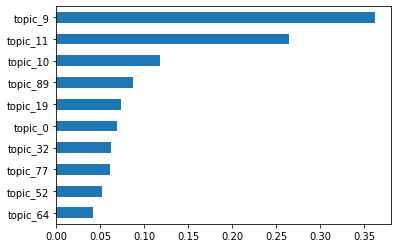

In [15]:
components.loc['do nothing democrats'].sort_values(ascending=False).head(10).plot.barh()
plt.gca().invert_yaxis()

In [16]:
show_topic_values('topic_9', 50)

array(['do nothing democrats', ', do nothing', 'do nothing',
       'the do nothing', 'nothing democrats', 'left , do',
       'nothing democrats ,', 'radical left ,', 'the radical left',
       'do nothing dems', 'radical left', 'nothing democrats are',
       'nothing democrats .', 'nothing democrats have', 'nothing',
       'to do nothing', 'radical left democrats', 'do nothing party',
       'do nothing radical', 'nothing democrats don',
       'the impeachment hoax', 'nothing democrats to', ', do',
       'do nothing democrat', 'do nothing ,', 'democrats , do',
       'nothing democrats &', 'nothing democrats were',
       'impeachment hoax', 'democrats', 'the do', 'nothing radical left',
       'do', 'nothing democrats !', 'the transcript !', '. do nothing',
       'a do nothing', '! do nothing', 'left ,',
       'nothing democrats corrupt', 'nothing democrats said',
       'nothing democrats “', 'nothing democrats get', 'do nothing with',
       'nothing democrats was', 'the rad

This allows us to see where each vocabulary entry ends up after being transformed, and the results seem to be more organized.

That looks really, really good. Let's visualize that to get a better feel of the distribution.

Topics 9 and 11 seem worth investigating to see if there is any other hostile behavior. The others may be interesting as well. Here's a handy little helper function for investigating topics.

In [17]:
show_topic_values('topic_11', 50)

array(['do nothing democrats', 'the do nothing', 'do nothing',
       ', do nothing', 'the united states', 'nothing democrats',
       'the radical left', 'left , do', 'nothing democrats ,',
       'radical left ,', 'do nothing dems', 'the do',
       'nothing democrats are', 'united states', 'nothing democrats have',
       'the united', 'nothing democrats .', 'to do nothing',
       'the whistleblower ?', 'of the united', 's the whistleblower',
       'do nothing with', 'do nothing party', 'radical left', 'nothing',
       'do nothing radical', 'our country', 'with the do',
       'nothing democrats to', 'the radical', 'of our country',
       'radical left democrats', 'where ’ s', 'united states is',
       'do nothing ,', 'with the united', ', do', 'our country !',
       '. do nothing', 'nothing democrats &', 'do',
       'nothing democrats very', 'of the do', 'for our country',
       'nothing democrats !', 'united states ,', 'nothing radical left',
       'whistleblower ?', 'dem

We can see that there's a lot of overlap between these two topics. These two seem to mostly have to do with democrats and what Trump calls the radical left. Let's see what other topics look like.

In [18]:
show_topic_values('topic_1', 50)

array(['p . m', '. m .', 'conference today at', 'm . thank',
       'thank you !', '. thank you', 'white house press',
       'press conference today', 'white house news',
       'house press conference', 'house news conference', 'm . eastern',
       'white house', 'a white house', 'news conference at', '5:30 p .',
       'news conference today', 'at 5:30 p', 'conference today',
       'eastern . thank', 'p .', '. m', 'm .', 'having a white',
       'today at 5:30', 'conference at 5:30', 'press conference',
       'conference at', 'thank you', 'press conference at',
       'news conference', '5:00 p .', 'conference at 5:45', '5:45 p .',
       '. thank', '5:30 p', 'today at', 'conference', 'today at 5:45',
       'at 5:45 p', 'at 5:00 p', 'today at 5:00', 'p', 'house press',
       'conference at 5:00', '. eastern .', 'be having a', 'm',
       'white house at', 'conference at white'], dtype=object)

This one seems to mostly have to do with conferences.

In [19]:
show_topic_values('topic_2', 50)

array(['% approval rating', '95 % approval', 'approval rating in',
       'the republican party', 'rating in the', 'approval rating',
       'republican party .', 'in the republican', '% approval', '95 %',
       'party . thank', 'republican party', 'rating in',
       'republican approval rating', 'republican party ,', 'thank you !',
       'the republican', '95 % ,', '. thank you', 'my approval rating',
       '95 % .', ', approval rating', '. 95 %', 'approval rating =',
       '. approval rating', 'approval rating overall',
       'approval rating ,', 'approval rating on', 'approval rating is',
       '= 95 %', 'is 95 %', 'party .', '96 % approval', '95 % !',
       'overall approval rating', 'approval', 'rating in republican',
       '% approval rate', '53 % approval', 'rating', '95 % a', 'now 95 %',
       '95', '52 % approval', '%', '39 % approval', '78 % approval',
       'republican party is', 'thank you', 'republican approval'],
      dtype=object)

This one seems to have to do with approval ratings.

In [20]:
show_topic_values('topic_3', 50)

array(['read the transcripts', 'the transcripts !', 'read the',
       'read the transcript', 'transcripts !', 'the transcripts', 'read',
       '. read the', ', read the', 'the transcript !', 'is read the',
       'read the republicans', 'to read the', 'just read the',
       'read the two', 'read the phone', 'i read the', '? read the',
       'but read the', 'transcripts', 'transcripts ! the',
       'the transcripts ,', 'transcripts ! “', 'transcripts ! a',
       'the transcripts .', 'transcripts ! also', 'transcripts ! schiff',
       '. read', 'own transcripts !', 'the transcripts that',
       'the transcripts )', 'transcript !', 'released the transcripts',
       'the transcript', ', read', 'understand the transcripts',
       'to read', 'and read', '! read', 'read it',
       'fabricate the transcripts', 'is read', 'read both transcripts',
       'just read', 'read to', 'read .', 'read ,', 'i read', '? read',
       'read this'], dtype=object)

This one seems to have to do with the transcripts during his impeachment.

In [21]:
show_topic_values('topic_4', 50)

array(['has my complete', 'and total endorsement', 'complete and total',
       'my complete and', 'total endorsement !', 'strong on crime',
       'he loves our', 'is strong on', 'loves our military',
       'total endorsement', 'loves our great', 'my complete', 'loves our',
       'has my', 'my complete endorsement', 'our #maga agenda',
       'complete and', 'loves our vets', 'strong on', 'vets and military',
       'our great vets', 'he has my', 'endorsement !', 'and total',
       'our military and', 'on crime and', 'our military',
       'complete endorsement !', 'great vets and', ', he loves',
       'he is strong', 'our vets', 'my total endorsement',
       'total endorsement for', 'our vets and', 'our great', 'he loves',
       'is strong', 'and loves our', 'total endorsement ,',
       'of our #maga', 'has my total', 'complete endorsement',
       'total endorsement .', 'border , he', 'and our vets',
       'for our military', 'our', 'our #maga', 'strong on our'],
      dtype

And this one seems to have to do with veterans, the military, and patriotism. 

When used as input data for classifiers, TruncatedSVD topics have shown to provide much greater accuracy (in my experience), and I think that seeing the internals of the topics like this, it makes sense. TruncatedSVD seems to be doing a very good job of creating topics. LDiA topics did not look nearly this organized, and I think that is why the classifier's scores suffered.

And now, let's do classification with those topics and see how well they do.

# Classification

First, I want to try classification using bag of words count vectors as our X input data.

In [22]:
X = svd_topic_vectors
y = labels

X = pd.DataFrame(X)
X.columns = ['topic_' + str(col) for col in X.columns]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1337, test_size=0.5)
X_train.shape, X_test.shape, len(y_train), len(y_test)

((716, 100), (716, 100), 716, 716)

In [23]:
lda = LDA(n_components=1, solver='lsqr', shrinkage=0.4)
lda.fit(X_train, y_train)
lda.score(X_train, y_train), lda.score(X_test, y_test)

(0.9078212290502793, 0.8952513966480447)

This is a very strong classifier. This is win-win, and what I set out to do a few days ago with LDiA. We now have a model that predicts very well, and we have interpretability into the topics. 

# Summarize Topics

I also want to see if I can use NLP to summarize our own topics, so that we can build a quick list of what each topic is about. Then we can use Lime to see how LDA is making its decisions and use the Lime output to investigate the topics. 

This will give us a much better understanding of NLP classification than I have ever seen, ever.

In [24]:
topic_array = show_topic_values('topic_9', 50)
topic_sent = ' '.join(topic_array)
topic_tokens = [word for word in topic_sent.split() if word.isalpha()]
token_counts = pd.Series(topic_tokens).value_counts()
token_counts[token_counts >= 5]

nothing      34
democrats    21
do           20
left          8
radical       8
the           6
dtype: int64

So, this simple process can give us a few words on what the topic is about. Let's turn that into a function and loop through the 100 total topics and see what is inside them. We can grab the topic names from the components dataframe we created before.

In [25]:
def get_topic_summary(topic):
    topic_array = show_topic_values(topic, 50)
    topic_sent = ' '.join(topic_array)
    topic_tokens = [word for word in topic_sent.split() if word.isalpha() and len(word) > 3]
    token_counts = pd.Series(topic_tokens).value_counts()
    return token_counts[token_counts >= 5]
                                    
get_topic_summary('topic_9')

nothing      34
democrats    21
left          8
radical       8
dtype: int64

I added len(word) > 3 as a very rudamentary way to remove stop words. we could also use a count vectorizer to create n-grams, but this gets the job done quickly for this proof of concept.

Now, let's loop through the topics and see what's in them.

In [26]:
for topic in components.columns:
    print(topic)
    summary = get_topic_summary(topic)
    print(summary)
    print('--------------------------------------')

topic_0
thank         10
house         10
conference     9
white          8
news           5
today          5
dtype: int64
--------------------------------------
topic_1
conference    16
house          8
today          8
white          7
thank          6
press          6
news           5
dtype: int64
--------------------------------------
topic_2
approval      23
rating        17
republican    10
party          7
dtype: int64
--------------------------------------
topic_3
read           30
transcripts    19
dtype: int64
--------------------------------------
topic_4
endorsement    11
total          10
loves           8
complete        8
vets            7
strong          6
military        5
dtype: int64
--------------------------------------
topic_5
conference    26
news          20
eastern       18
dtype: int64
--------------------------------------
topic_6
whistleblower    34
where            12
dtype: int64
--------------------------------------
topic_7
interviewed    13
tonight     

dtype: int64
--------------------------------------
topic_76
being    6
dtype: int64
--------------------------------------
topic_77
sleepy    6
order     5
dtype: int64
--------------------------------------
topic_78
order    6
dtype: int64
--------------------------------------
topic_79
impeachment    10
hoax            6
account         5
dtype: int64
--------------------------------------
topic_80
rally    12
dtype: int64
--------------------------------------
topic_81
sleepy    32
biden     13
jobs       6
dtype: int64
--------------------------------------
topic_82
sleepy    33
biden     17
dtype: int64
--------------------------------------
topic_83
jobs     9
today    6
from     5
live     5
dtype: int64
--------------------------------------
topic_84
happy        10
president     8
past          6
call          5
ukrainian     5
phone         5
dtype: int64
--------------------------------------
topic_85
impeachment    5
dtype: int64
--------------------------------------
topi

Topic 14 seems to be all about "presidential harassment", so let's see what's in there.

In [27]:
show_topic_values('topic_14', 20)

array(['presidential harassment !', 'presidential harassment',
       'harassment !', '. presidential harassment', 'harassment',
       'presidential', 'the presidential', '. presidential',
       'of presidential', 'in presidential', 'on presidential',
       'a presidential', 'as presidential', 'presidential debates',
       'democrat presidential', 'presidential news',
       'presidential candidate', 'my presidential', 'of the presidential',
       'presidential medal'], dtype=object)

So, it's more than just presidential harassment. It's about anything presidential. Very interesting.

Topic 17 seems to be about second amendment rights, so let's see if that's the case.

In [28]:
show_topic_values('topic_17', 20)

array(['out and vote', 'get out and', 'and vote for',
       'your 2nd amendment', 'your second amendment', 'and vote',
       'protect your second', 'vote for', 'protect your 2nd',
       'will protect your', 'get out', 'vote for eddie',
       '2nd amendment .', '2nd amendment', ', get out', '. get out',
       'protect your', 'vote for @eddierispone', 'and vote republican',
       'vote'], dtype=object)

And it is. And what's even more impressive is that we have "2nd amendment" and "second amendment" both in this topic. So, topic modeling is doing what it should be doing.

Topic 20 seems to be about fake news, so let's check that out.

In [29]:
show_topic_values('topic_20', 50)

array(['the fake news', 'fake news', 'fake news media', 'fake news !',
       'fake news .', 'the fake', '. fake news', 'fake news is',
       'news media', 'fake news would', 'fake news to', 'much fake news',
       'the united states', 'and fake news', 'fake', 'often fake news',
       'fake news ,', 'is fake news', 'fake news @cnn',
       'fake news sources', 'or fake news', 'news', 'allows fake news',
       '& fake news', 'in the fake', 'fake news &', 'by fake news',
       'fake news @nytimes', 'fake news story', 'a fake news',
       'fake news cnn', 'not fake news', 'of fake news', 'fake news that',
       'that fake news', 'fake news wants', 'fake news )', '! fake news',
       ', fake news', 'fake news msdnc', 'fake news said',
       'fake news new', 'in the history', 'the lamestream media',
       '( fake news', 'more fake news', 'fake news will',
       'lamestream media', 'are fake news', 'fake news and'], dtype=object)

Yep, that worked well.

So, in short, TruncatedSVD topics were previously very effective, but they were not interpretable. Now they are. This is a nice improvement.

# Classifier Interpretability

Let's also use Lime to investigate how the classifier is making predictions.

In [30]:
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, training_labels=y_train, feature_names=X_train.columns)

In [31]:
row = 0

exp = explainer.explain_instance(X.values[row], lda.predict_proba, num_features=10)
exp.show_in_notebook(show_table=True)

In [32]:
tweets[0]

'no matter what you do for the do nothing democrats, no matter how great a job you are doing, they will only respond to their fake partners in the lamestream media in the negative, even in a time of crisis. i thought it would be different, but it’s not. in fact, it’s even worse...'

In [33]:
show_topic_values('topic_9', 10)

array(['do nothing democrats', ', do nothing', 'do nothing',
       'the do nothing', 'nothing democrats', 'left , do',
       'nothing democrats ,', 'radical left ,', 'the radical left',
       'do nothing dems'], dtype=object)

So this gives us visitility into how the classifier is making decisions. Now have visibility into topic formation and classifier decision-making, and that is really great interpretability. This is a massive increase in topic visibility and the results are even better than I ever had with LDiA.

# Topic Hostility Graph

For the last piece of interpretability, I want to create a topic hostility graph, where the nodes are the tweets and topics and the edges are the tweet's assignment to a topic. I will use the top three topics that a tweet is weighted toward. Hostile tweets will have red edges, and non-hostile will have green.

In [34]:
row_topics = []

for index, row in X.iterrows():
    primary_topics = sorted(row.sort_values(ascending=False)[0:3].index.values)
    row_topics.append(primary_topics)

In [35]:
class_df = pd.DataFrame({'topics':row_topics, 'label':y})
class_df = class_df.explode('topics')
class_df.reset_index(inplace=True) # so that previous row numbers become a feature
class_df.columns = ['tweet', 'topic', 'label']
class_df.head()

,tweet,topic,label
0,0,topic_23,1
1,0,topic_33,1
2,0,topic_39,1
3,1,topic_10,1
4,1,topic_12,1


And now we are ready to load this into a networx graph. I prefer to do graph creation using networkx and then graph visualization using scikit-network. Graphs are more difficult to visualize in networkx and more difficult to construct in scikit-network, so this works very well. Scikit-network also currently has very limited graph analysis capabilities compared to networkx, so this approach gets you the best of both worlds.

First, import the libraries.

In [36]:
import networkx as nx
import sknetwork as sk

from IPython.display import SVG

from sknetwork.data import Bunch, load, save
from sknetwork.ranking import PageRank, BiPageRank
from sknetwork.utils import edgelist2adjacency, edgelist2biadjacency
from sknetwork.visualization import svg_graph, svg_digraph, svg_bigraph

from scipy import sparse

In [37]:
G = nx.from_pandas_edgelist(class_df, source='tweet', target='topic')

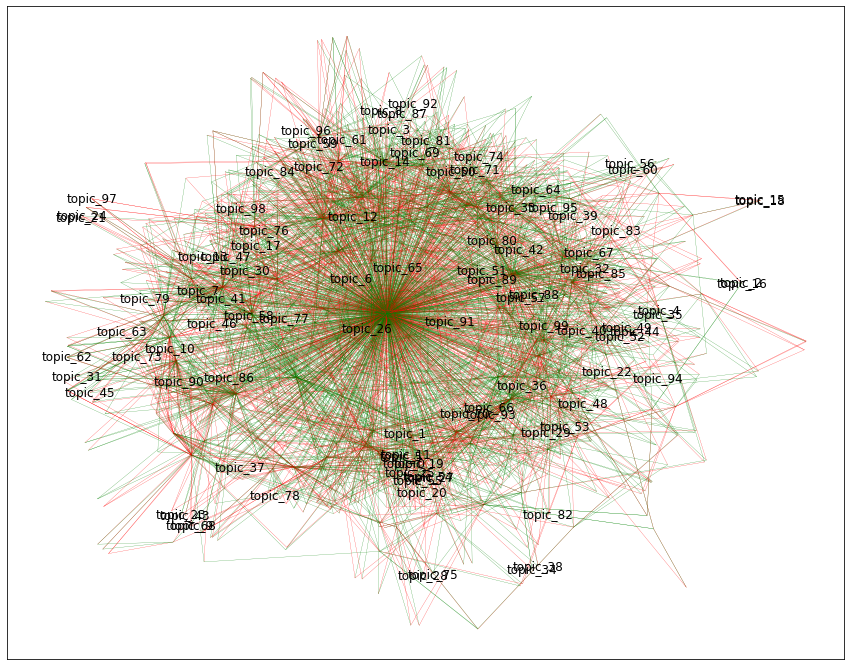

In [38]:
label_colors = {
   1: 'red',
   0: 'green'
}

colors = y.map(label_colors)

# remove the row names; we just want the topics
node_names = ['' if str(node).isnumeric() else node for node in G.nodes]
node_idx = range(len(node_names))
node_names = dict(zip(node_idx, node_names))
node_names = {key:val for key, val in node_names.items() if val != ''}

plt.subplots(figsize=(15,12))

nx.draw_networkx(G, node_size=0, width=0.2, edge_color=colors, labels=node_names)

This is definitely a bit difficult to read, but you can see that certain topics appear to have more red around them than green. We could use an ego graph to zoom in on individual topics, but this is enough of a graph demonstration for now. Let's move on and I may revisit this on another day. For now, let's just consider the graph more messy than valuable, but there's potential. This graph did not come out well, but the input data will be helpful.

Even from class_df, though, we can see which topics are associated with the most hostility. So, let's see how frequently each topic is associated with each label.

In [39]:
class_label_df = class_df.groupby(['topic', 'label']).count().reset_index()
class_label_df.columns = ['topic', 'label', 'count']

pvt_topic_clf = pd.pivot_table(class_label_df, index='topic', columns='label', values='count').fillna(0)
pvt_topic_clf['total'] = pvt_topic_clf.sum(axis=1)
pvt_topic_clf[0] = pvt_topic_clf[0] / pvt_topic_clf['total']
pvt_topic_clf[1] = pvt_topic_clf[1] / pvt_topic_clf['total']
pvt_topic_clf.drop('total', axis=1, inplace=True)
pvt_topic_clf.head()

label,0,1
topic,,
topic_0,0.574600,0.425400
topic_1,1.000000,0.000000
topic_10,0.813953,0.186047
topic_11,0.263889,0.736111
topic_12,0.619048,0.380952


Now that that's in place, let's quickly visualize it.

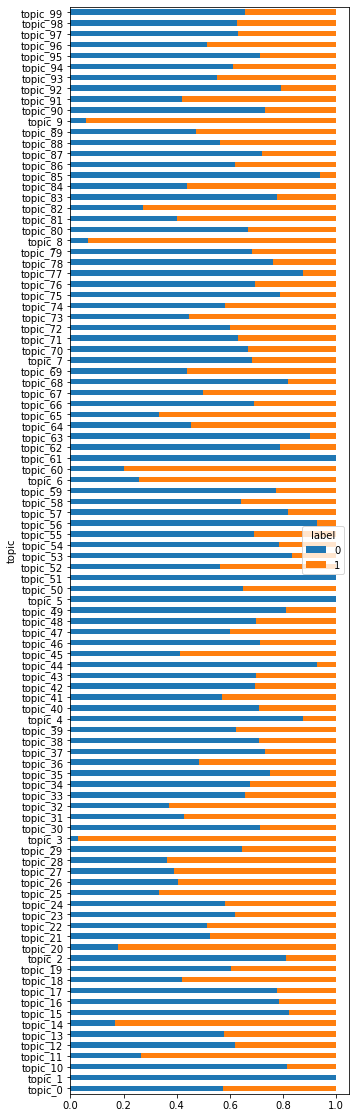

In [40]:
_= pvt_topic_clf.plot.barh(stacked=True, figsize=(5,20))

We can clearly see that some topics are assiciated with hostility more than others. Topics that stand out are 3, 8, 9, and 14. But let's sort these and see if there are others.

In [41]:
pvt_topic_clf.sort_values(1, ascending=False).head(5)

label,0,1
topic,,
topic_3,0.027778,0.972222
topic_9,0.059524,0.940476
topic_8,0.066667,0.933333
topic_14,0.166667,0.833333
topic_20,0.178082,0.821918


So, let's inspect those. Topic 82 is especially interesting, as I didn't make it that far in reading the topic summaries.

In [42]:
show_topic_values('topic_14', 20)

array(['presidential harassment !', 'presidential harassment',
       'harassment !', '. presidential harassment', 'harassment',
       'presidential', 'the presidential', '. presidential',
       'of presidential', 'in presidential', 'on presidential',
       'a presidential', 'as presidential', 'presidential debates',
       'democrat presidential', 'presidential news',
       'presidential candidate', 'my presidential', 'of the presidential',
       'presidential medal'], dtype=object)

In [43]:
show_topic_values('topic_3', 20)

array(['read the transcripts', 'the transcripts !', 'read the',
       'read the transcript', 'transcripts !', 'the transcripts', 'read',
       '. read the', ', read the', 'the transcript !', 'is read the',
       'read the republicans', 'to read the', 'just read the',
       'read the two', 'read the phone', 'i read the', '? read the',
       'but read the', 'transcripts'], dtype=object)

In [44]:
show_topic_values('topic_8', 20)

array(['the transcript !', 'read the transcript', 'transcript !',
       'the transcript', 'transcript', 'the transcript .',
       'of the transcript', 'the transcript of', 'transcript ! i',
       'in the transcript', 'on the transcript', 'transcript ! there',
       'the transcript ,', 'released the transcript',
       'week the transcript', 'seeing the transcript',
       'releasing the transcript', 'the transcript leads', 'transcript .',
       'transcript of'], dtype=object)

In [45]:
show_topic_values('topic_9', 20)

array(['do nothing democrats', ', do nothing', 'do nothing',
       'the do nothing', 'nothing democrats', 'left , do',
       'nothing democrats ,', 'radical left ,', 'the radical left',
       'do nothing dems', 'radical left', 'nothing democrats are',
       'nothing democrats .', 'nothing democrats have', 'nothing',
       'to do nothing', 'radical left democrats', 'do nothing party',
       'do nothing radical', 'nothing democrats don'], dtype=object)

In [46]:
show_topic_values('topic_82', 20)

array(['sleepy joe biden', 'sleepy joe', 'to sleepy joe', 'joe biden',
       'joe biden !', 'sleepy joe !', 'joe biden ,', 'joe biden ’',
       'sleepy joe ’', 'joe biden .', '. sleepy joe', 'sleepy joe ,',
       'congratulations to sleepy', 'joe biden in', 'joe biden will',
       '. joe biden', 'supporting sleepy joe', 's sleepy joe',
       'will sleepy joe', ', sleepy joe'], dtype=object)

So he is most hostile about presidential harassment and the "impeachment hoax" and he is constantly on the attack against the radical left, do no thing democrats, and Joe Biden.

And, so, there you have it. We've taken TruncatedSVD, which was not very interpretable, and found a way to make topics interpretable. We can now inspect tf-idf, topics, and classification, and we also drew a hostility graph that shows some clustering of topics. And finally, we simply aggregated the input dataframe for that graph to more easily figure out which topics were associated with what label.

This same exact workflow can be used on any topic modeling classification investigation. This is the deepest interpretability I have ever seen in any NLP project, so I hope you find this as useful as I have.